# Homework 1


## Installing libraries

In [ ]:
! pip install geopy > /dev/null
! pip install --pre scapy[basic] > /dev/null
! pip install pythonping > /dev/null
! apt-get install curl > /dev/null

In [ ]:
import requests
import socket
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scapy.all import *
from statistics import mean

## Functions

In the following sections are defined the functions used in the rest of the notebook:



*   **extract_url**(filename, verbose = False): with this function it is possible to extract urls that uses http as protocol. The input file must be a .txt file since the search is based on **regex**.  
*   **get_ip_list**(urls_list, verbose = False): using the socket.gethostbyname(hostname) it is possible to retrieve the list of IP addresses.
*   **compute_RTT**(target, n_samples, verbose = False): computes the mean of the RTT based on *n_samples*. The RTT is computed through the elapsed time between an ICMP echo-request and an echo reply.
*   **traceroute**(target, verbose = False): this function allows to retrieve the IP address of all the answering routers in the path between source and destination.



In [ ]:
def extract_url(filename, verbose = False):

    #Given a specific list it finds the
    with open(filename, "r") as f:
        text = f.read()

    # With a regex we extract the strings
    # 'https://mirror.its.dal.ca/'
    # from a generic text
    #Regex:
    # http(with or without s):// continues with alphanumeric value or a dot
    urls = re.findall(r"https?://[\w\.-]*", text)

    if verbose:
      print(urls)

    extracted_urls = []

    for url in urls:
        # Then we remove the part http:// and the last part / to get
        # 'mirror.csclub.uwaterloo.ca'
        # we start from 'https://mirror.csclub.uwaterloo.ca'
        # we use split and get ['https', 'mirror.csclub.uwaterloo.ca']
        # and we get the second element of the list
        extracted_urls.append(url.split("://")[1])

    if verbose:
      print(extracted_urls)

    return extracted_urls

In [ ]:
def get_ip_list(urls_list, verbose = False):

  ip_list = []
  for url in urls_list:
    try:

      # Using get host by name we retrieve the ip address
      # from the url
      # if some error occur we add to the list a None value
      # in order to remove it later
      ip_add = socket.gethostbyname(url)
      ip_list.append(ip_add)

      if verbose:
        print(ip_add)
    except:
      if verbose:
        print("IP NOT FOUND")
        ip_list.append(None)

  return ip_list

In [ ]:
def compute_RTT(target, n_samples, verbose = False):
  pck = IP(dst=target)/ICMP()
  RTT = []

  if verbose:
    print(f"Sending packets to: {target}", end = " ")

  for i in range(n_samples):

    ans, unans = sr(pck,verbose=False, timeout = 1)

    if verbose:
      # It will print one . for every packet sent
      print(f"{'.'}", end = " ")

    if ans is not None and len(ans) > 0:
      query = ans[0][0]
      resp = ans[0][1]

      if resp.src == target:

        RTT.append((resp.time-query.sent_time)*1000)

      else:
        print("DID not answer since the source is not the target")
        break


    else:
      # we break and stop asking to the server
      # if it is not answering
      print("DID NOT RECEIVED ANSWER")
      break

  if len(RTT) > 0:

    if verbose:
      print()
    return mean(RTT)


  # if mean there is no element inside the list it will return 0
  # this will be used to filter the data
  return 0

In [ ]:
def traceroute(target, verbose = False):

  path = []

  for ttl in range(1, 64):
    pck = IP(dst=target)/ICMP()
    pck.ttl = ttl

    ans, unans = sr(pck,verbose=False, timeout = 1)

    if ans is not None and len(ans) > 0:
      query = ans[0][0]
      resp = ans[0][1]
      path.append(resp.src)

      if verbose:
        print(f"Receiving from: {resp.src}")

      if resp.src == target:
        break


  return path

## Obtaining positions of IP addresses/servers  

In [ ]:
# Extracting the url list with a terminal command
!curl https://www.gnu.org/prep/ftp.html > file_1.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47754    0 47754    0     0  83732      0 --:--:-- --:--:-- --:--:-- 83632


In [ ]:
# Extracting the url list with a terminal command
!curl https://www.debian.org/mirror/list > file_2.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103k  100  103k    0     0   198k      0 --:--:-- --:--:-- --:--:--  198k


In [ ]:
"""
HERE IS IT POSSIBLE TO CHANGE THE NAME OF THE FILE
"""
urls = extract_url("file_2.txt")

addresses = get_ip_list(urls)

#Since some ip addresses are the same we have to filter them
# In this way we can filter based on the address
# when we find the same address the url get overwritten

address_url_dict = {addresses[i]:urls[i] for i in range(len(addresses)) if addresses[i] is not None}

In [ ]:
print(urls[:5])
print(addresses[:5])

['www.w3.org', 'search.debian.org', 'bits.debian.org', 'micronews.debian.org', 'planet.debian.org']
['104.18.23.19', '194.177.211.202', '130.89.148.77', '130.89.148.77', '151.101.22.132']


In [ ]:
# we create a dicitonary for inserting position information
# in order to get the position information we use a API
# ipinfo.io

address_pos_dict = {}

for address, url in address_url_dict.items():

    url = f'https://ipinfo.io/{address}/json'
    try:
        # Send GET request to the API
        response = requests.get(url)

        # Check if the request was successful
        if response.status_code == 200:
            # Parse JSON response
            data = response.json()

            # the data.get('loc') is a string so we convert it into
            # a tuple of floats
            position = tuple([float(i) for i in data.get('loc').split(',')])

            address_pos_dict[address] = position

        else:
            print(f"Error: {response.status_code}")

    except Exception as e:
        print(f"An error occurred: {e}")

In [ ]:
# Printing the first value to verify correctness
count = 0
for address, position in address_pos_dict.items():
    count += 1
    print(f"Address: {address}    Position: {position}")

    if count >5:
      break

Address: 104.18.23.19    Position: (37.7621, -122.3971)
Address: 194.177.211.202    Position: (37.9757, 23.7691)
Address: 130.89.148.77    Position: (52.2183, 6.8958)
Address: 151.101.22.132    Position: (47.6062, -122.3321)
Address: 128.31.0.62    Position: (42.3751, -71.1056)
Address: 195.192.210.132    Position: (47.7994, 13.044)


In [ ]:
# Once we have the position of all the servers for the debian distribution
# we can save it in a csv file
# to do that we use pandas
data = {}
data["IP"] = address_pos_dict.keys()
data["Name"] = [address_url_dict[address] for address in address_pos_dict.keys()]
data["Lat"] = [address_pos_dict[address][0] for address in address_pos_dict.keys()]
data["Long"] = [address_pos_dict[address][1] for address in address_pos_dict.keys()]
df = pd.DataFrame.from_dict(data)
df = df.dropna()

In [ ]:
# It is possible also to save the resulting CSV file
df.to_csv("Data.csv")

In [ ]:
df.head()

,IP,Name,Lat,Long
0,104.18.23.19,www.w3.org,37.7621,-122.3971
1,194.177.211.202,search.debian.org,37.9757,23.7691
2,130.89.148.77,micronews.debian.org,52.2183,6.8958
3,151.101.22.132,deb.debian.org,47.6062,-122.3321
4,128.31.0.62,www.debian.org,42.3751,-71.1056


## How to get your position (colab or local)

To get the position of your server inside google colab you can use the following code. This will work even by executing the

In [ ]:
import urllib.request
import json

api='https://api.ipify.org'

ip=urllib.request.urlopen(api).read().decode('UTF-8')

print(f'My IP is:{ip}')

info = json.loads(urllib.request.urlopen('http://ip-api.com/json/'+ip).read())
#print(info)
print(f'My city is: {info["city"]}')
print(f'My country is: {info["country"]}')
print(f"My latitude is: {info['lat']}")
print(f"My longitude is {info['lon']}")

My IP is:34.127.75.187
My city is: The Dalles
My country is: United States
My latitude is: 45.5945
My longitude is -121.1786


In [ ]:
! curl 'https://api.ipify.org?format=json'

{"ip":"34.127.75.187"}

In [ ]:
my_position = (info['lat'], info['lon'])
print(my_position)

(45.5945, -121.1786)


## How to get your precise position (local)
You could also get your exact position using an open source geocoding software which can be used through **geopy** library :**Nominatim**.

In this way we can insert our position more precisely.

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent = "Mattia Fiore")
location = geolocator.geocode("piazza leonardo da vinci milano")

In [ ]:
print(location)
print(f"Lat: {location.latitude} - Long: {location.longitude}")

Piazza Leonardo da Vinci, Città Studi, Municipio 3, Milano, Lombardia, Italia
Lat: 45.47814205 - Long: 9.224804735660399


In [ ]:
my_position = (location.latitude, location.longitude)

## How to compute distances

In [ ]:
from geopy import distance

Text(0.5, 0, 'Distance [km]')

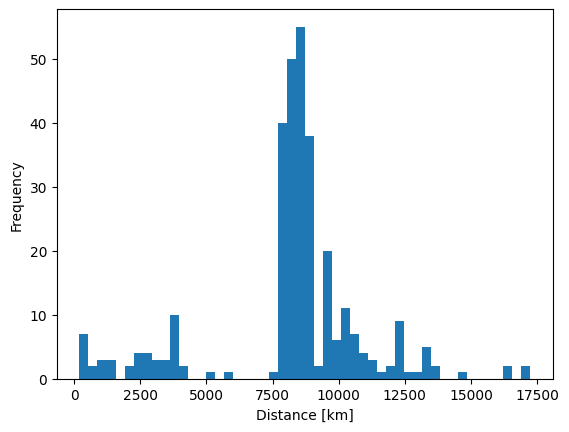

In [ ]:
df = pd.read_csv("Data.csv",  index_col=0)
df["distance"] = df.apply(lambda row: distance.distance((row["Lat"], row["Long"]), my_position).km , axis=1)
df["distance"].plot.hist(bins = 50)

plt.xlabel("Distance [km]")

## Computing RTT

We'll compute the RTT for some of the addresses in the dataset called Data.csv.


In [ ]:
"""
Since the number of server can be quite big and the amount of time needed
to run the code can be quite high considering that we have to do a number of RTT
"""
# If it is set to True the dataframe will be sampled randomly
sample = True

if sample == True:
  # It is possible to change the n_ip in order to increse or the decrease
  # the amount of server sampled
  n_ip = 50
  df = df.sample(n_ip)
else:
  pass
dictionary = {i: 0 for i in df["IP"]}

# It is possible to change the number of pings
n_ping_per_server = 3

for target in dictionary.keys():

    dictionary[target] = compute_RTT(target, n_ping_per_server, verbose = True)



Sending packets to: 208.100.4.53 . . . 
Sending packets to: 142.147.88.7 . . . 
Sending packets to: 94.154.159.241 . . . 
Sending packets to: 108.61.5.92 . . . 
Sending packets to: 184.105.240.111 . . . 
Sending packets to: 78.142.193.130 . . . 
Sending packets to: 204.157.3.70 . . . 
Sending packets to: 129.240.118.47 . . . 
Sending packets to: 77.120.62.8 . . . 
Sending packets to: 129.27.3.13 . DID NOT RECEIVED ANSWER
Sending packets to: 95.168.211.41 . . . 
Sending packets to: 185.248.160.60 . . . 
Sending packets to: 185.100.87.86 . . . 
Sending packets to: 195.234.45.114 . . . 
Sending packets to: 128.135.10.29 . . . 
Sending packets to: 40.64.88.253 . . . 
Sending packets to: 210.28.130.3 . . . 
Sending packets to: 95.128.34.165 . DID not answer since the source is not the target
Sending packets to: 216.127.35.166 . DID NOT RECEIVED ANSWER
Sending packets to: 133.5.166.3 . DID NOT RECEIVED ANSWER
Sending packets to: 77.247.64.34 . . . 
Sending packets to: 193.136.216.34 . DID NO

In [ ]:
# adding the RTT to the dataframe
df["RTT"] = df.apply(lambda row: dictionary[row["IP"]], axis = 1)

In [ ]:
df.head()

,IP,Name,Lat,Long,distance,RTT
294,208.100.4.53,mirror.steadfast.net,41.8721,-87.6578,2711.820820,49.358686
296,142.147.88.7,mirrors.xtom.com,37.3394,-121.8950,918.777689,17.144283
299,94.154.159.241,nyc.mirrors.clouvider.net,40.7185,-74.0025,3818.985596,58.824301
279,108.61.5.92,debian.mirror.constant.com,40.4993,-74.3990,3798.439594,66.885551
287,184.105.240.111,mirror.keystealth.org,37.4419,-122.1430,909.013080,21.929502


## Verifying correctness of the ping results

In [ ]:
! apt-get install iputils-ping > /dev/null

This command line was used to verify the correctness of the RTT computation.

In [ ]:
!ping mirror.linux.ro

PING mirror.linux.ro (81.196.9.142) 56(84) bytes of data.
64 bytes from mirror.linux.ro (81.196.9.142): icmp_seq=1 ttl=59 time=127 ms
64 bytes from mirror.linux.ro (81.196.9.142): icmp_seq=2 ttl=59 time=127 ms
64 bytes from mirror.linux.ro (81.196.9.142): icmp_seq=3 ttl=59 time=127 ms
64 bytes from mirror.linux.ro (81.196.9.142): icmp_seq=4 ttl=59 time=127 ms

--- mirror.linux.ro ping statistics ---
4 packets transmitted, 4 received, 0% packet loss, time 3002ms
rtt min/avg/max/mdev = 126.762/126.859/127.040/0.106 ms


## Plotting points

In [ ]:
# The function retrieves RTT = 0 if there are no answers
# So we just filter the values which are bigger than 0
df = df[df["RTT"] > 0]

The formula for the RTT should be close to:
$$RTT \simeq 2\frac{distance}{cn}$$

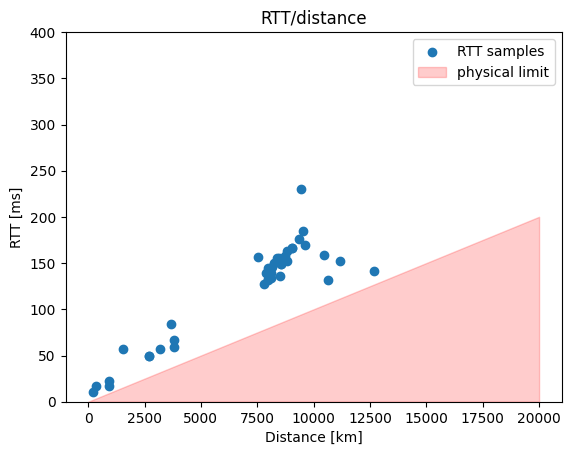

In [ ]:
plt.scatter(df["distance"], df["RTT"] )
speed_light_in_fiber = 199_861_638 # [m/s]
speed = speed_light_in_fiber / 1_000_000 #[km/ms]
max_distance = 20_000 #[km] the maximumn distance between two points

plt.stackplot([0, max_distance], [0, 2*(max_distance/speed)], alpha = 0.2, color = "r")
plt.xlabel("Distance [km]")
plt.ylabel("RTT [ms]")
plt.title("RTT/distance")
plt.ylim(0,400)
plt.legend(["RTT samples", "physical limit"])

The mean values of RTT cannot be under the redline. Since information cannot travel faster than light. Sometimes it may happen that some points are inside the red region but this is due to the imprecision in the geolocalization.

## Linear Interpolation of data

In [ ]:
interpol = np.polyfit(df["distance"], df["RTT"], deg = 1)

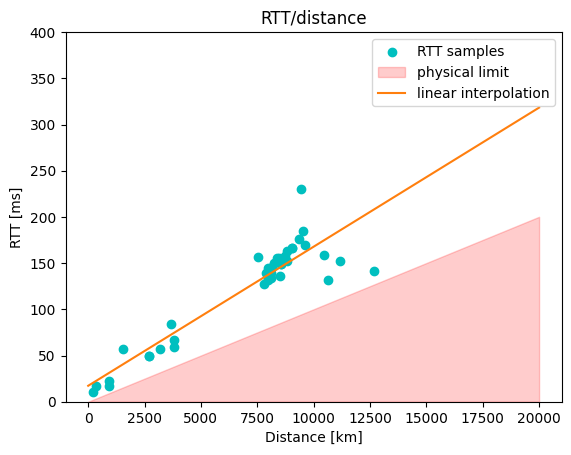

In [ ]:
plt.scatter(
    df["distance"],
    df["RTT"],
    color = "c")

speed_light_in_fiber = 199_861_638 # [m/s]
speed = speed_light_in_fiber / 1_000_000 #[km/ms]
max_distance = 20_000 #[km] the maximumn distance between two points
# we need to convert in km/ms
plt.stackplot([0, max_distance], [0, 2*(max_distance/speed)], alpha = 0.2, color = "r")
plt.plot(np.linspace(0, max_distance, 200), [interpol[1] + interpol[0]*i for i in np.linspace(0, max_distance, 200)])

plt.xlabel("Distance [km]")
plt.ylabel("RTT [ms]")
plt.title("RTT/distance")
plt.ylim(0,400)
#plt.xlim(0,max(x))
plt.legend(["RTT samples", "physical limit", "linear interpolation"])

## Higher accuracy distance computation

The distance computed by the geopy library is the minimum distance between the two points on Earth.
Since the optical connection will surely take different routes than the fastest one, the overall travelled distance will result bigger.

For this reason we could also redraw the graph by recomputing the distance with higher accuracy using the **traceroute**.

By computing the list of all routers traversed and by computing the distance between each one we can increase the accuracy of the distance travelled by the packet.

Of course the accuracy on the computation will depend on the amount of routers that will replay to the ICMP echo request.

In [ ]:
list_paths = {i:[] for i in df["IP"]}
for address in df["IP"]:


  #print(f"The address is: {address}")
  path = traceroute(address, verbose = False)
  # we add the path to the
  list_paths[address] = path


In [ ]:
# We add the path to the dataframe
df["path"] = df.apply(lambda row: list_paths[row["IP"]], axis = 1)

In [ ]:
# Then we compute the position through the API
# This will result in a path of traversed nodes

# I use tuples since i cannot use list as keys because
# they are immutable
list_path_pos = {tuple(i):[] for i in df["path"]}

verbose = False

for path in df["path"]:

    path_pos = []
    for address in path:
        #print(f"Address: {address}")
        url = f'https://ipinfo.io/{address}/json'
        try:
            # Send GET request to the API
            response = requests.get(url)

            # Check if the request was successful
            if response.status_code == 200:
                # Parse JSON response
                data = response.json()

                # the data.get('loc') is a string so we convert it into
                # a tuple of floats

                position = tuple([float(i) for i in data.get('loc').split(',')])
                path_pos.append(position)
                #print(f"Position: {position}")

            else:
              if verbose:
                print(f"Error: {response.status_code}")


        except Exception as e:
          if verbose:
            print("Error occurred")

    list_path_pos[tuple(path)] = path_pos

In [ ]:
df["path_pos"] = df.apply(lambda row: list_path_pos[tuple(row["path"])], axis = 1)


In [ ]:
# You can also do not ran it.
df = df[df["path_pos"].apply(lambda row: len(row) > 1)]

In [ ]:
df.head()

,IP,Name,Lat,Long,distance,RTT,path,path_pos
294,208.100.4.53,mirror.steadfast.net,41.8721,-87.6578,2711.820820,49.358686,"[172.28.0.1, 62.115.132.154, 62.115.126.159, 2...","[(41.85, -87.65), (41.85, -87.65), (41.85, -87..."
279,108.61.5.92,debian.mirror.constant.com,40.4993,-74.3990,3798.439594,66.885551,"[172.28.0.1, 213.200.112.170, 173.205.45.234, ...","[(40.7143, -74.006), (40.7143, -74.006), (40.4..."
287,184.105.240.111,mirror.keystealth.org,37.4419,-122.1430,909.013080,21.929502,"[172.28.0.1, 209.85.241.183, 72.52.92.245, 184...","[(45.5946, -121.1787), (37.3394, -121.895), (3..."
285,204.157.3.70,mirror.cogentco.com,38.8951,-77.0364,3670.158066,84.296862,"[172.28.0.1, 66.249.94.186, 64.86.123.101, 63....","[(45.5946, -121.1787), (47.6062, -122.3321), (..."
257,77.120.62.8,debian.volia.net,50.4547,30.5238,9018.461148,166.615407,"[172.28.0.1, 209.85.245.32, 82.144.192.136, 77...","[(50.4547, 30.5238), (50.4547, 30.5238), (50.4..."


In [ ]:
import geopy

# we recompute the distanace point to point
distance_list = []
for list_pos in df["path_pos"]:

    dist= 0
    for i in range(len(list_pos)):

        if i == 0:
            #we need to add the starting position
            dist += geopy.distance.distance(my_position, list_pos[i]).km

        else:
            dist += geopy.distance.distance(list_pos[i], list_pos[i-1]).km

    distance_list.append(dist)


In [ ]:
df["distance_2"] = distance_list

In [ ]:
df["difference"] = df["distance_2"] - df["distance"]

# This is done to verify that there are no points where the distance
# decrese, since it is not possible.
df[df["difference"] < 0].shape

(0, 10)

In [ ]:
df.to_csv("Complete_data.csv")

In [ ]:
df[["distance", "distance_2", "RTT"]].head()

,distance,distance_2,RTT
294,2711.820820,2715.816674,49.358686
279,3798.439594,3859.849830,66.885551
287,909.013080,961.473982,21.929502
285,3670.158066,6015.233633,84.296862
257,9018.461148,9018.461148,166.615407


In [ ]:
interpol = np.polyfit(df["distance"], df["RTT"], deg = 1)
interpol2 = np.polyfit(df["distance_2"], df["RTT"], deg = 1)

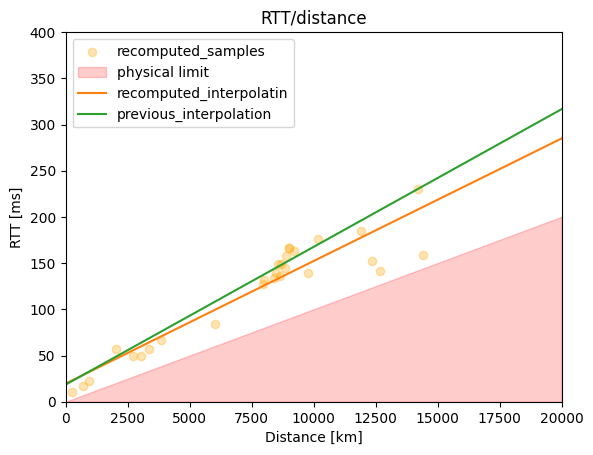

In [ ]:
plt.scatter(
    df["distance_2"],
    df["RTT"],
    color = "orange",
    alpha = 0.3)


speed_light_in_fiber = 199_861_638 # [m/s]
speed = speed_light_in_fiber / 1_000_000 #[km/ms]
max_distance = 20_000 #[km] the maximumn distance between two points

plt.stackplot([0, max_distance], [0, 2* (max_distance/speed)], alpha = 0.2, color = "r")
plt.plot(np.linspace(0, max_distance, 200), [interpol2[1] + interpol2[0]*i for i in np.linspace(0, max_distance, 200)])
plt.plot(np.linspace(0, max_distance, 200), [interpol[1] + interpol[0]*i for i in np.linspace(0, max_distance, 200)])

plt.xlabel("Distance [km]")
plt.ylabel("RTT [ms]")
plt.title("RTT/distance")
plt.ylim(0,400)
plt.xlim(0,20_000)
plt.legend(["recomputed_samples", "physical limit", "recomputed_interpolatin", "previous_interpolation"])

## Commenting the results

The interpolation of the RTT measures shows a linear dependence between the distance at which the server is positioned and the RTT. This result is coherent with the theoretical formula.

Indeed, if the distance is computed only by considering the sender and the receiver the slope of the line is much bigger than the physical limit one.

Instead if we try to compute the distance using the traceroute mechanism we will get a much more accurate measurement of the distance travelled by the packet. This will result in a line with a slope very close to the one of the physical limit.

Still it will be bigger since for increasing distances the amount of routers that we are going to traverse will be bigger and this will increase the overall delay.



## Plotting Route

In [ ]:
! pip install folium

In [ ]:
# Taking the row with the biggest difference in distance
# between the two computation
row = df.loc[df["difference"].idxmax()]

In [ ]:
# Or the one with the more hops
row = df.loc[df['path_pos'].apply(lambda x: len(x)).idxmax()]

In [ ]:
path = [my_position] + list(row["path_pos"])

In [ ]:
import folium

mymap = folium.Map()
for i in range(len(path)-1):

  folium.PolyLine(locations=[path[i], path[i+1]], color='blue').add_to(mymap)

mymap.save('map.html')

In [ ]:
mymap